### **Training Details**  
- **GPU:** NVIDIA L4  
- **GPU Memory:** 22.5 GB  
- **Platform:** Colab Pro  

**🔹 Recommended:** Use a GPU with **≥ 19GB VRAM**


#### Hugging Face (HF) login. Get access token from HF website.
#### This is needed for 2 reasons:
1. paligemma-3b-pt-224 (Google's VLM) is a gated repo so HF authentication required.
2. to push finetuned model to HF (optional but reccomended)


In [1]:
from huggingface_hub import notebook_login
notebook_login()

##### Dependencies needed to install.

In [2]:
!pip install torch transformers BitsAndBytes peft datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [20]:
import torch
import random
import matplotlib.pyplot as plt
from transformers import (
    AutoProcessor,
    PaliGemmaForConditionalGeneration,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer
)
from peft import get_peft_model, LoraConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from PIL import Image



### keep a note that `google/paligemma-3b-pt-224`is gated model, that means you need to take access permission on Hugging Face to use.
#### Ask for permission to use paligemma from its HuggingFace page.
#### Check your Gated Repo status on Hugging Face [here](https://huggingface.co/settings/gated-repos)

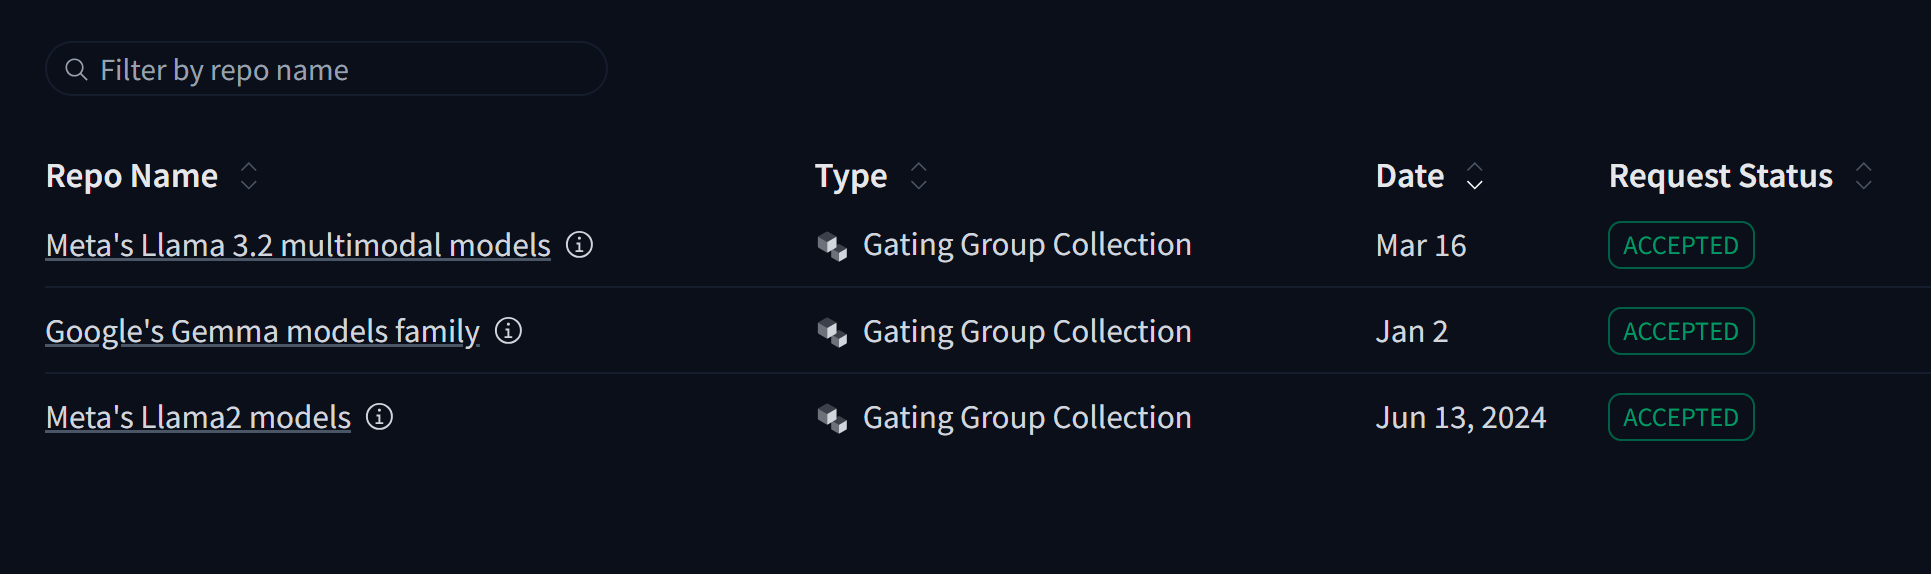

In [5]:
from types import SimpleNamespace

# Directly define arguments
args = SimpleNamespace(
    model_id="google/paligemma-3b-pt-224",
    output_dir="paligemma_intersections"
)


In [6]:

# Configuration
dataset_id = "ariG23498/intersection-dataset" # change this if want to use different dataset
model_id = args.model_id
device = "cuda:0"
dtype = torch.bfloat16
batch_size = 8



More details for the interaction dataset can be found [here](https://huggingface.co/datasets/ariG23498/intersection-dataset)

The dataset has **3000** train rows and **300** validation rows.
            

In [7]:

# Load dataset
train_ds = load_dataset(dataset_id, split='train')
val_ds = load_dataset(dataset_id, split='validation')



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/517 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.6M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

In [8]:
# Model configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)


In [9]:

# Initialize model and processor
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, device_map=device)
model = get_peft_model(model, lora_config)
processor = AutoProcessor.from_pretrained(model_id)


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

#### Sample Dataset Check

In [10]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 3000
})

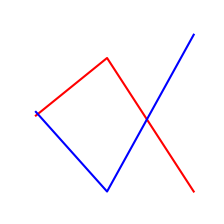

In [33]:
train_ds[2902]["image"]

In [34]:
train_ds[2902]["label"]

2

In [11]:
def run_inference(val_dataset, processor, model):
    val_sample = random.choice(val_dataset)
    image = val_sample["image"].convert("RGB")
    inputs = processor(
        images=[image],
        text=["<image> How many intersections are there between the lines"],
        return_tensors="pt",
    ).to(torch.bfloat16)
    input_len = inputs["input_ids"].shape[-1]
    with torch.no_grad():
        generation = model.generate(**inputs.to(model.device), max_new_tokens=10)
        generation = generation[0][input_len:]
        decoded = processor.decode(generation, skip_special_tokens=True)

    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Pred: {decoded}")
    plt.show()

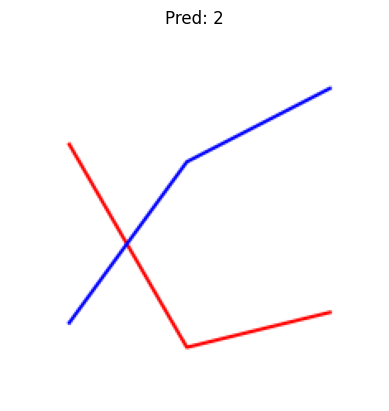

In [12]:
# run inference before training
run_inference(val_ds, processor, model)

In [14]:

# Training configuration
training_args = TrainingArguments(
    num_train_epochs=2,
    remove_unused_columns=False,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    warmup_steps=2,
    learning_rate=2e-5,
    weight_decay=1e-6,
    adam_beta2=0.999,
    logging_steps=100,
    optim="adamw_bnb_8bit",
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=1,
    output_dir=args.output_dir,
    bf16=True,
    report_to=None, #["wandb"],
    dataloader_pin_memory=False,
)


In [17]:

# Data collation function
def collate_fn(examples):
    images = [example["image"].convert("RGB") for example in examples]
    prompt = ["<image> How many intersections are there between the lines" for _ in examples] # Prompt: How many intersections are there between the lines
    suffix = [str(example['label']) for example in examples]

    inputs = processor(
        images=images,
        text=prompt,
        suffix=suffix,
        return_tensors='pt',
        padding='longest'
    )

    inputs = inputs.to(dtype).to(device)
    return inputs


In [18]:

# Initialize trainer
trainer = Trainer(
    model=model,
    train_dataset=train_ds,
    data_collator=collate_fn,
    args=training_args
)


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Main cell to finetune the model.
Will need W&b API key.


### You will be asked **Weights & Biases** API after running below cell. Get it from [here](https://wandb.ai/site/).

#### **Weights & Baises** record and display training metrics in realtime, similar to below image.

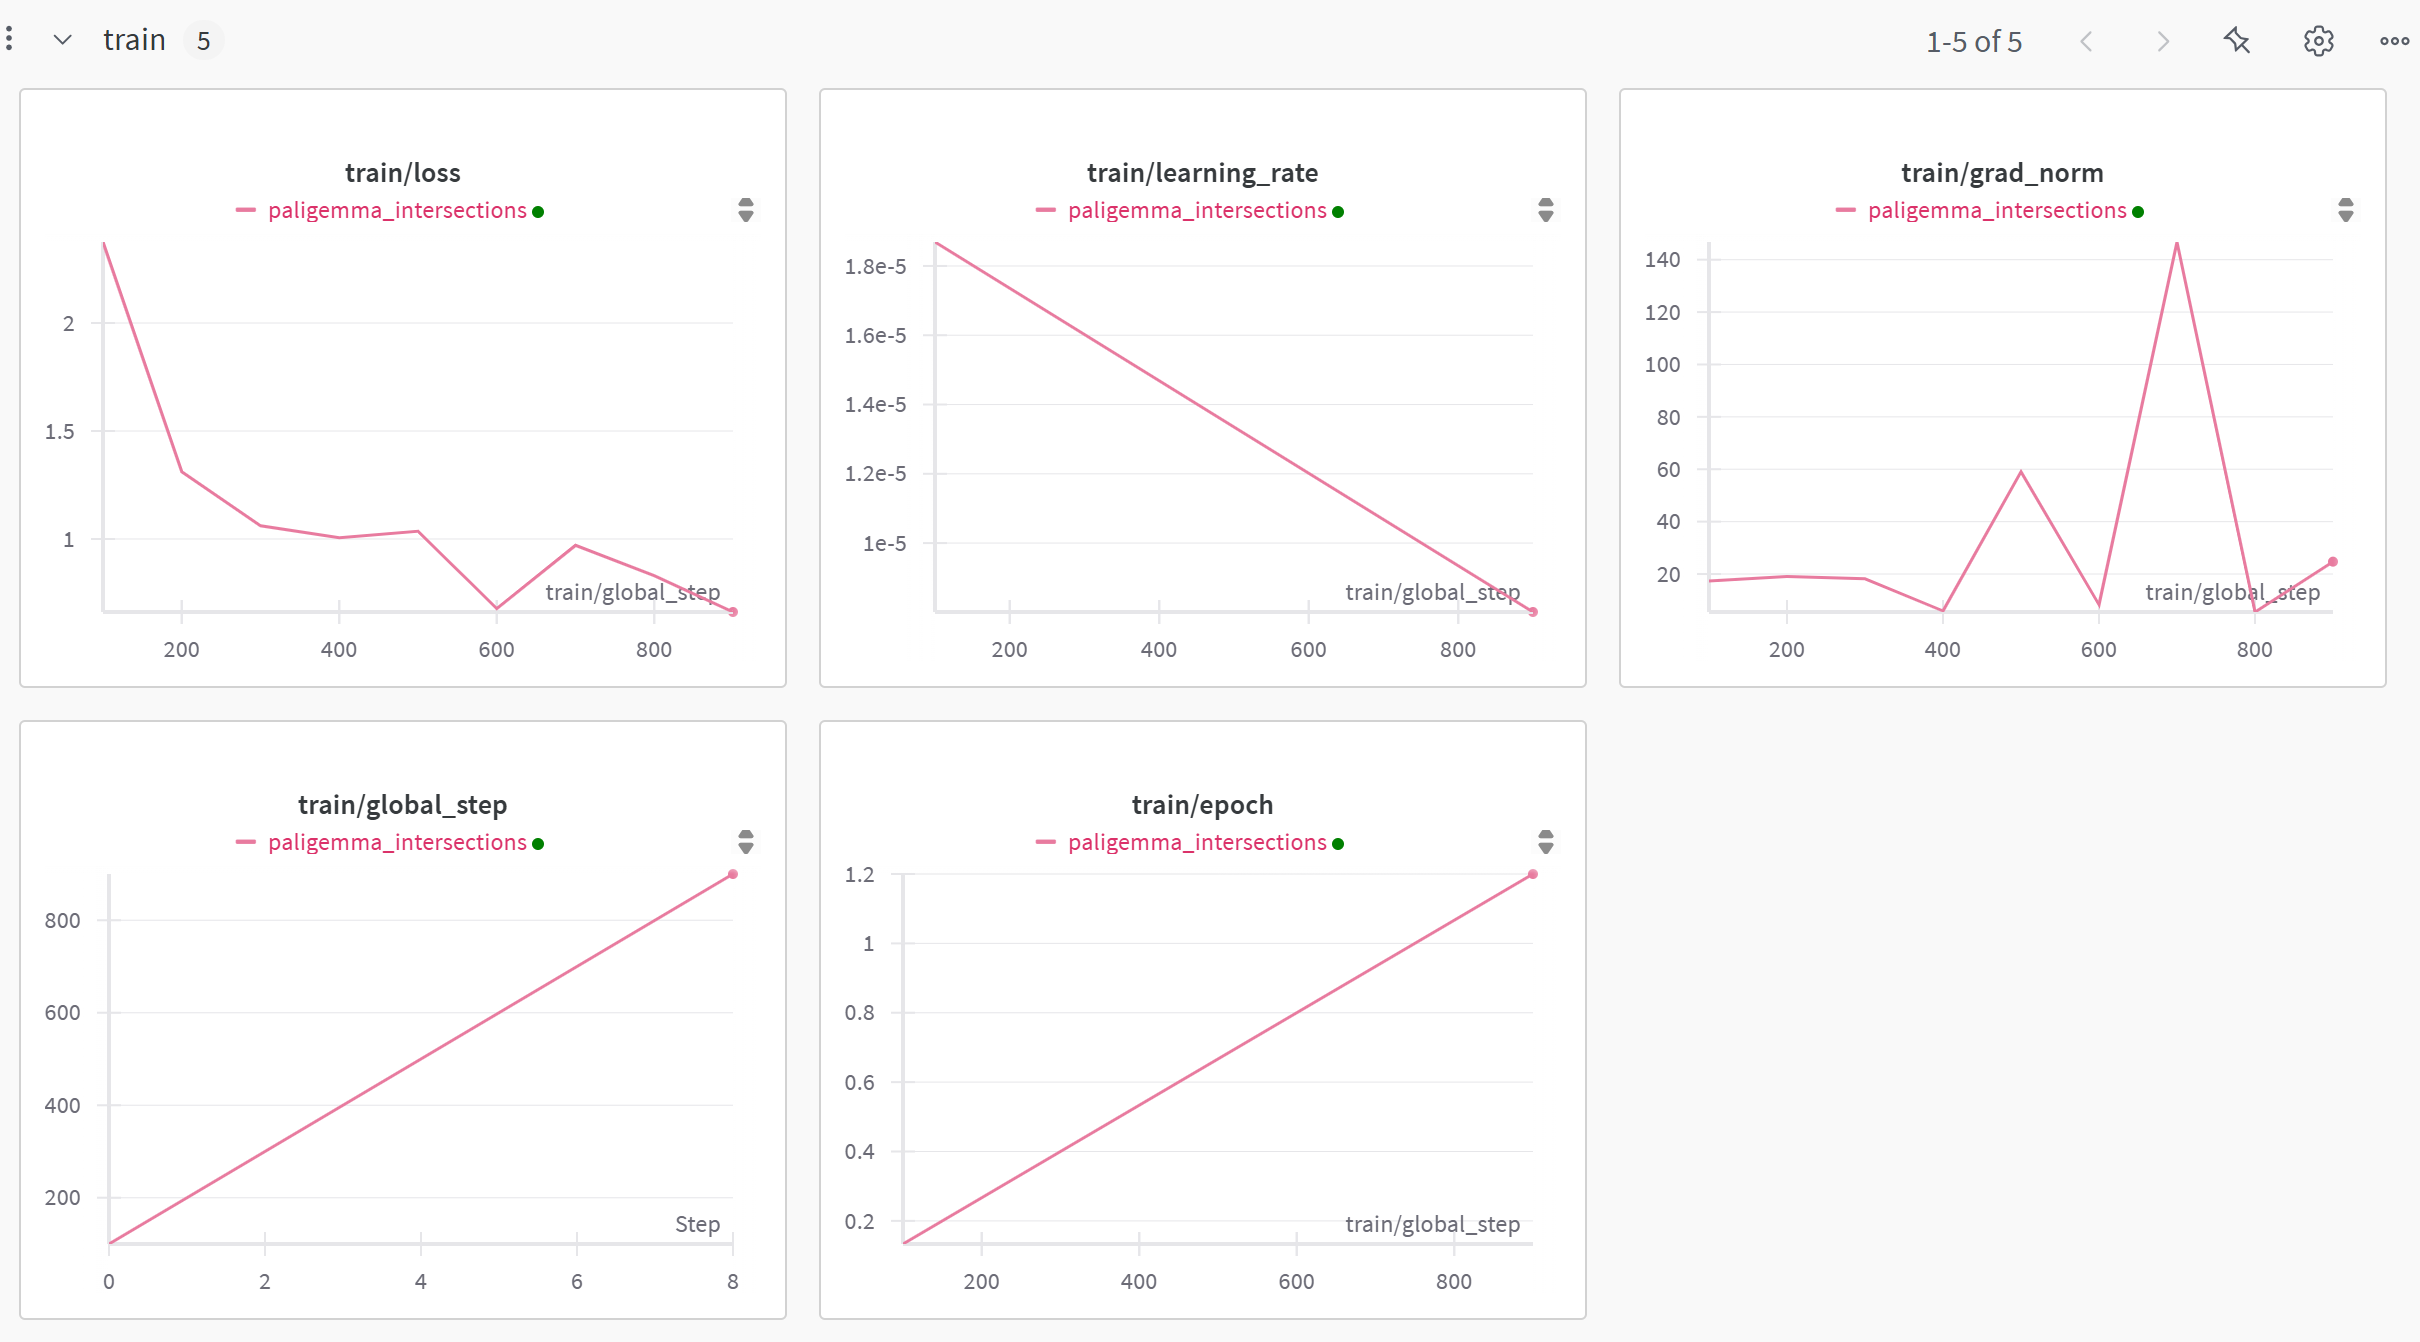

In [19]:

# Start training
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mlap (mlap-BITS Pilani) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
100,2.374900
200,1.311100
300,1.061300
400,1.006300
500,1.035600
600,0.677900
700,0.970900
800,0.830400
900,0.662100
1000,0.606300


Step,Training Loss
100,2.374900
200,1.311100
300,1.061300
400,1.006300
500,1.035600
600,0.677900
700,0.970900
800,0.830400
900,0.662100
1000,0.606300


TrainOutput(global_step=1500, training_loss=0.9187407633463541, metrics={'train_runtime': 2034.2202, 'train_samples_per_second': 2.95, 'train_steps_per_second': 0.737, 'total_flos': 2.3229412570368e+16, 'train_loss': 0.9187407633463541, 'epoch': 2.0})

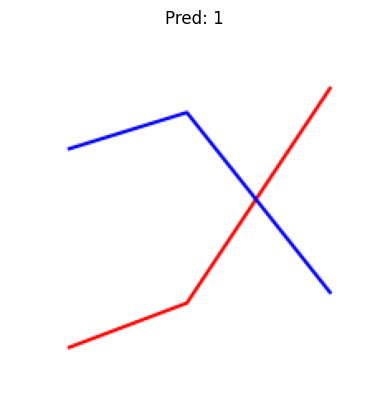

In [25]:
# run inference after training
run_inference(val_ds, processor, model)


### Save your finetuned model to Hugging Face for future inference. Check saved model [here](https://huggingface.co/MLap/paligemma_intersections)

In [26]:

#push the model to the huggingface hub
trainer.push_to_hub('PaliGemma-Count-Intersecting-Line')
trainer.create_model_card()

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1743497049.2ba9cd9865d0.257.0:   0%|          | 0.00/9.37k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]